# Energy-Magnitude notebook

Ampitude measurements, such as RSAM and Reduced Displacement, do not effectively capture the size of an event because some events of equal amplitude may be of very different durations. So it is useful to estimate the energy of the event. Furthermore, because event energy can range of several orders of magnitude, it is useful to define an energy magnitude.

We compute Reduced Energy ($E_R$, units: J) via the equation:

$E_R = 2 \pi r^{2}  \frac{\rho_{E} c_{E}}{A} \int {S^{2} {U(t)}^2} dt$

(Boatwright, 1980; Johnson and Aster, 2005). 

Since this includes a correction for geometrical spreading, we will call it Reduced Energy ($E_{R}$).

The quantity ---- is similar to RSEM (Real-time Seismic Energy Measurement) but computed on a velocity seismogram rather than a raw seismogram, so we call it VSEM.

And then following Hanks and Kanamori (1???), we define Energy-Magnitude ($M_{E}$) as:

(Started doing this in March 2000 at Montserrat Volcano Observatory... lots of complaints!)

$M_{E} = \frac{2}{3} log_{10} E_R - 3.2$

(The factor 3.2 might change depending on velocity structure).

We will now compute $E_{R}$ and $M_{E}$ for the same events we examined in the Reduced Displacement tutorial.

References:

- Boatwright, 1980
- Johnson & Aster, 2005
- VSEM?
- Hanks and Kanamori, 1980?


## 2. Computing Reduced Energy ($E_R$)

DSAM is just an instrument-corrected version of RSAM, and Reduced Displacement is just DSAM corrected for geometrical spreading, and so SAM.py was written to support all these different measurements. Here is an algorithm:

1. Load raw seismic data as an ObsPy Stream object.
2. Load station/instrument response metadata from a StationXML file into an Obspy Inventory object.
3. Remove instrument response to convert Stream object to a displacement seismogram.
4. Compute DSAM data from this displacement seismogram. 
6. Define a fixed source location.
7. Compute distance from station to source (done internally using source and inventory)
8. "Reduce" the DSAM object by multiplying by geometrical spreading correction.

### 2.1 Simple example

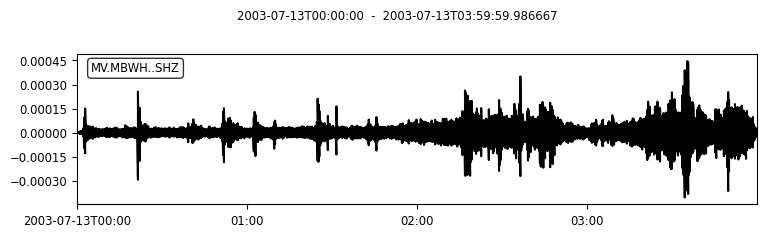

             time        energy           VLP            LP            VT
0    1.058054e+09  6.237954e-11  7.263240e-12  3.999897e-09  6.990619e-10
1    1.058054e+09  4.068340e-10  2.326646e-11  2.640933e-08  4.210885e-09
2    1.058055e+09  5.056250e-08  2.224410e-10  3.638353e-06  1.608005e-07
3    1.058055e+09  1.462265e-08  2.350768e-10  1.025831e-06  7.442018e-08
4    1.058055e+09  7.528239e-09  3.982056e-10  5.359782e-07  3.012084e-08
..            ...           ...           ...           ...           ...
235  1.058068e+09  1.034412e-07  1.747246e-09  6.896701e-06  8.401819e-07
236  1.058069e+09  7.542829e-08  6.404522e-10  5.247071e-06  4.954861e-07
237  1.058069e+09  3.921785e-08  4.470905e-10  2.653757e-06  3.041818e-07
238  1.058069e+09  2.556619e-08  1.636275e-09  1.714905e-06  2.144956e-07
239  1.058069e+09  2.631396e-09  2.698171e-11  1.728949e-07  2.575512e-08

[240 rows x 5 columns]
Metrics: energy,VLP,LP,VT
Sampling Interval=60.0 s

MV.MBWH..SHZ: 2003-07-13T00:00:00 to

In [1]:
import os
import sys
import obspy
sys.path.append('lib')
from SAM import VSEM

# Load raw seismic data - and set units accordingly
DATA_DIR = os.path.join('data')
SDS_DIR = os.path.join(DATA_DIR, 'continuous','SDS')
SAM_DIR = os.path.join(DATA_DIR, 'continuous','SAM')
RESPONSE_DIR = os.path.join(DATA_DIR, 'responses')

#mseedfile = os.path.join(SDS_DIR,'2009','AV','REF','EHZ.D', 'AV.REF..EHZ.D.2009.081' )
mseedfile = os.path.join(SDS_DIR,'2003','MV','MBWH','SHZ.D', 'MV.MBWH..SHZ.D.2003.194' )
st = obspy.read(mseedfile, 'MSEED')

# load instrument response, remove instrument response from seismogram
#stationxml = os.path.join(RESPONSE_DIR, 'RD.xml')
stationxml = os.path.join(RESPONSE_DIR, 'MV.xml')
inv = obspy.read_inventory(stationxml)

# remove instrument response - and set units accordingly IMPORTANT!
#pre_filt = [0.01, 0.02, 25, 50]
pre_filt = [0.1, 0.2, 18, 25]
st.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL", plot=False) 
st.plot()

#################################################
# So far we just have a velocity seismogram
#################################################

# Generate a Velocity Seismic Energy Measurement (VSEM) object
vsemObj = VSEM(stream=st, sampling_interval=60)
print(vsemObj)

The units of energy, VLP, LP, and VT here are $m^2/s$. But we can convert them to Joules and M_E if we define a sum and call the `sum_energy` method:

{'lat': 16.7164, 'lon': -62.1654}
METRIC:  energy


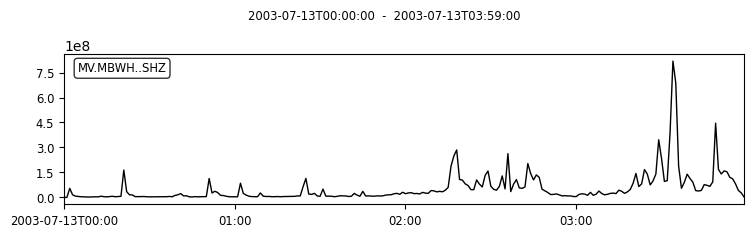

MV.MBWH..SHZ: Joules: 1.27e+10, Magnitude: 4.6
Network: Joules: 1.27e+10, Magnitude: 4.6


In [2]:
# Define a source location for SHV. Station distances to this lat/lon are used to "reduce" the displacement to 1 km distance.
source = {'lat':16.7164, 'lon':-62.1654}  
print(source)

# Generate a Reduced Energy object, assuming body waves (surfaceWaves=False) and no inelastic attenuation (Q=None)
ERobj = vsemObj.compute_reduced_energy(inv, source, Q=None)
ERobj.plot(metrics='energy')

# Compute Energy Magnitude
E, ME = ERobj.sum_energy()

## 3. Comparing the Reduced Energy of several eruptions

1-minute VSEM data have been pre-computed for several eruptions. We will now load these, compute $E_R$, and compare them. The general syntax we will use to read VSEM data and compute $E_R$ is:

```
vsemObj = VSEM.read(startTime, endTime, SAM_DIR='/path/to/DSAM/data/directory', sampling_interval=sampling_interval, ext=ext)
ERobj = vsemObj.compute_reduced_energy(inventory, source, Q=None)
```
We will capture the highest $E_R$ into a results DataFrame, resultsDF.

For reasons that will become clearer later, we will compute  $E_R$ in two frequency bands. 
- The default is 0.5-18.0 Hz, the standard one we used for computing RSAM data previously.
-  The second is a VLP passband, from 0.02 to 0.2 Hz.

We write a function, compute_reduced_energies, so we don't have to keep repeating the same code block:

In [3]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import obspy
sys.path.append('../lib')
#import setup_paths
#paths = setup_paths.paths
from SAM import DSAM

resultsDF = pd.DataFrame(columns=['Event', 'sum(ER)', 'ME', 'sum(ER_VLP)', 'ME_VLP'])

def compute_reduced_energies(eventname, vsemObj, source, stationxml, resultsDF):
    vsemObj = vsemObj.select(component='Z')
    inv = obspy.read_inventory(stationxml)
    
    # reduced energy
    ERobj = vsemObj.compute_reduced_energy(inv, source)
    ERobj.plot(metrics='energy')
    sumE, ME = ERobj.sum_energy(metric='energy')
    ERobjBB = ERobj.select(channel='[BH]HZ')
    if len(ERobjBB)>0:
        sumE_VLP, ME_VLP = ERobjBB.sum_energy(metric='VLP')
    else:
        #sumE_VLP, ME_VLP = ERobj.sum_energy(metric='VLP')
        sumE_VLP = 0
        ME_VLP = -np.Inf
    
    # add to results
    resultsDF.loc[len(resultsDF.index)] = [eventname, sumE, ME, sumE_VLP, ME_VLP]
   

### 3.1 Event 1: Boxing Day Collapse 1997, Montserrat

29 months into the eruption of the Soufriere Hills Volcano, Montserrat, part of the crater wall the lava dome was growing within (and overtopping) suddenly collapsed in a landslide, causing a sideways explosion of the lava dome which effectively removed all traces of villages in the southwest quadrant of Montserrat (the villages had been evacuated more than a year earlier). At this time, there were only 2 stations operational, due to months of pyroclastic flows which had destroyed the capital, Plymouth, the airport, numerous other villages, and several seismic stations, and it was much too dangerous to replace them.

Reading  data/continuous/SAM/VSEM_MV.MBWH..SHZ_1997_60s.pickle
Reading  data/continuous/SAM/VSEM_MV.MBLG..SHZ_1997_60s.pickle
METRIC:  energy


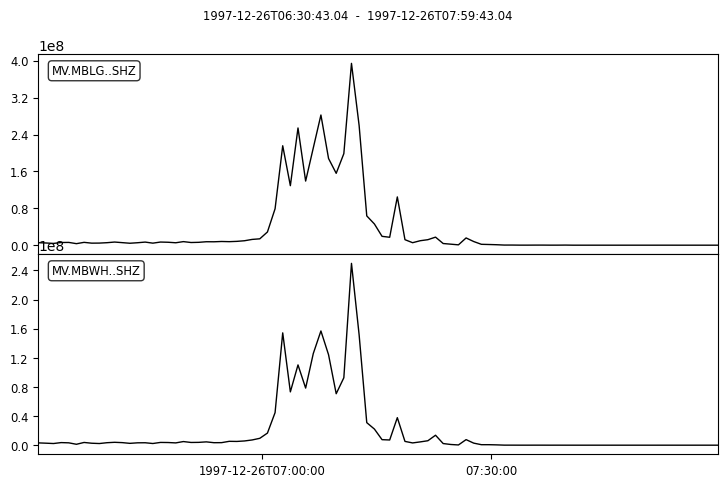

MV.MBWH..SHZ: Joules: 1.72e+09, Magnitude: 4.0
MV.MBLG..SHZ: Joules: 3.07e+09, Magnitude: 4.2
Network: Joules: 2.40e+09, Magnitude: 4.1


In [4]:
# Event name
eventname1 = 'Boxing Day Collapse 1997'
source1 = {'lat':16.71111, 'lon':-62.17722}
stationxml1 = os.path.join(RESPONSE_DIR, 'MV.xml')
startt1 = obspy.UTCDateTime(1997,12,26,6,30,0)
endt1 = obspy.UTCDateTime(1997,12,26,8,0,0)
vsemObj1 = VSEM.read(startt1, endt1, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', trace_ids=['MV.MBWH..SHZ', 'MV.MBLG..SHZ'])
compute_reduced_energies(eventname1, vsemObj1, source1, stationxml1, resultsDF)

We go no value in the VLP passband because there are no broadband seismometers, and by correcting short-period seismic data down to 50-s period, we'd only be blowing up the noise and getting unrealistically large values ($M_E$ ~ 6).

### 3.2 July 12th 2003 Dome collapse, Montserrat
On July 12th, 2003, over 200 million ${m}^3$ of the lava dome collapse in a series of explosions and pyroclastic flows, over a few hours. Let's compare the $E_R$ of this event to the Boxing Day 1997 collapse we just examined. Since this collapse happened mostly down the Tar River Valley, we will pick a source location there, rather than one centred on the lava dome.

Reading  data/continuous/SAM/VSEM_MV.MBGH..BHZ_2003_60s.pickle
Reading  data/continuous/SAM/VSEM_MV.MBLG..SHZ_2003_60s.pickle
Reading  data/continuous/SAM/VSEM_MV.MBRY..BHZ_2003_60s.pickle
Reading  data/continuous/SAM/VSEM_MV.MBSS..SHZ_2003_60s.pickle
Reading  data/continuous/SAM/VSEM_MV.MBWH..SHZ_2003_60s.pickle
METRIC:  energy


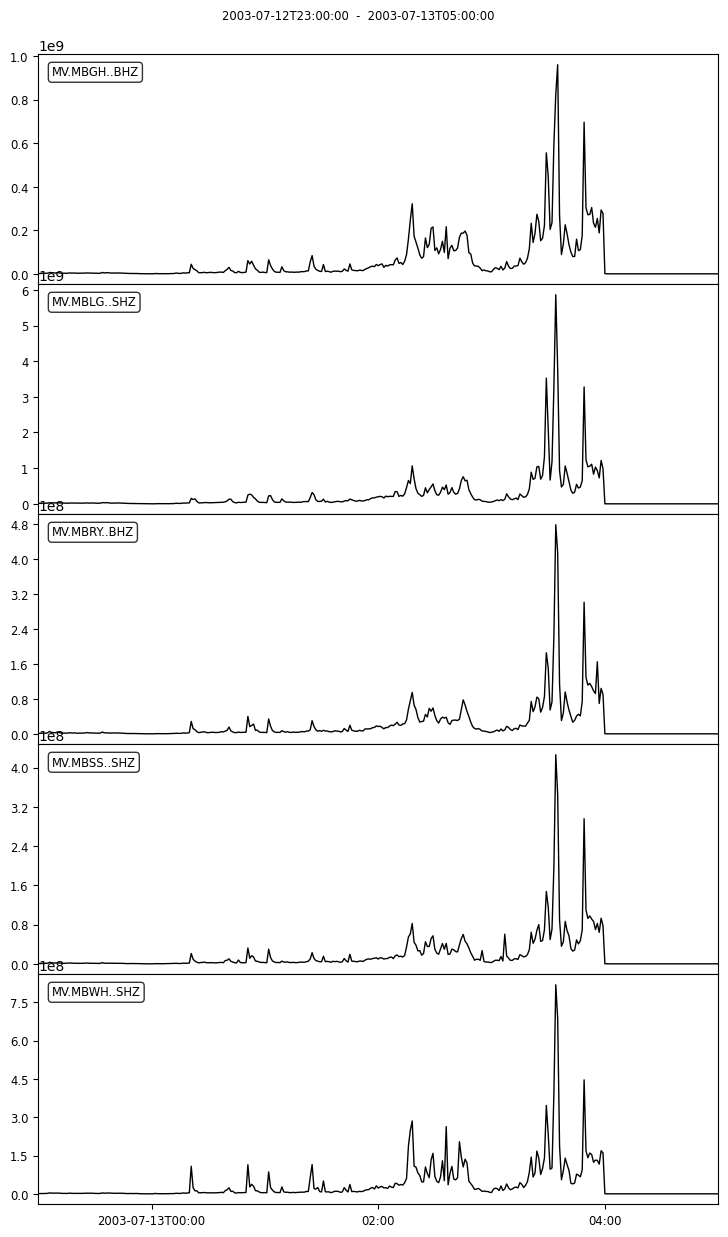

MV.MBGH..BHZ: Joules: 1.93e+10, Magnitude: 4.7
MV.MBLG..SHZ: Joules: 8.15e+10, Magnitude: 5.1
MV.MBRY..BHZ: Joules: 7.27e+09, Magnitude: 4.4
MV.MBSS..SHZ: Joules: 6.20e+09, Magnitude: 4.4
MV.MBWH..SHZ: Joules: 1.31e+10, Magnitude: 4.6
Network: Joules: 1.31e+10, Magnitude: 4.6
MV.MBGH..BHZ: Joules: 6.30e+08, Magnitude: 3.7
MV.MBRY..BHZ: Joules: 9.66e+08, Magnitude: 3.9
Network: Joules: 7.98e+08, Magnitude: 3.8


In [5]:
eventname2 = '2003/07/12 collapse, Montserrat'
stationxml2 = os.path.join(RESPONSE_DIR, 'MV.xml')
source2 = {'lat':16.7164, 'lon':-62.1654}  # Tar River
source2 = {'lat':16.7164, 'lon':-62.1654}  # Tar River
startt2 = obspy.UTCDateTime(2003,7,12,23,0,0)
endt2 = obspy.UTCDateTime(2003,7,13,5,0,0)
vsemObj2 = VSEM.read(startt2, endt2, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                    trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])
compute_reduced_energies(eventname2, vsemObj2, source2, stationxml2, resultsDF)

### 3.3 Phreatic eruption, Whakaari, Dec 9th, 2019

Whakaari - otherwise known as White Island - is the subaerial tip of a 1600 m high volcano that rises from the seafloor. Tourists arriving by boat and helicopter take a short hike into an open volcanic crater, past fumaroles, to an overlook of the crater lake. Phreatic eruptions are particularly difficult to forecast, as unlike magmatic eruptions, there are no seismic precursors (or indeed any other precuroses) that have been identified. Sadly, this particulary eruption led to the deaths of 22 tourists and guides. Let's compute the $E_R$ and $M_E$ of this event.


data/continuous/SAM/VSEM_*_2019_60s.pickle
Reading  data/continuous/SAM/VSEM_NZ.WSRZ.10.HHZ_2019_60s.pickle
Reading  data/continuous/SAM/VSEM_NZ.WIZ.10.HHZ_2019_60s.pickle


/Users/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


METRIC:  energy


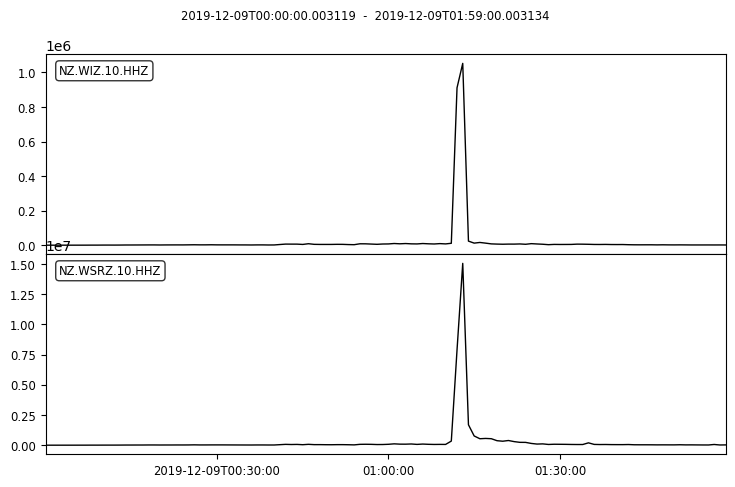

NZ.WSRZ.10.HHZ: Joules: 3.34e+07, Magnitude: 2.9
NZ.WIZ.10.HHZ: Joules: 2.44e+06, Magnitude: 2.1
Network: Joules: 1.79e+07, Magnitude: 2.5
NZ.WSRZ.10.HHZ: Joules: 8.15e+06, Magnitude: 2.5
NZ.WIZ.10.HHZ: Joules: 1.53e+07, Magnitude: 2.7
Network: Joules: 1.17e+07, Magnitude: 2.6


In [6]:
eventname3 = '2019/12/09 Phreatic explosion, Whakaari'
stationxml3 = os.path.join(RESPONSE_DIR, 'NZ.xml')
source3 = {'lat':-37.5217, 'lon':177.185}
startt3 = obspy.UTCDateTime(2019,12,9,0,0,0)
endt3 = obspy.UTCDateTime(2019,12,9,2,0,0)
vsemObj3 = VSEM.read(startt3, endt3, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle')
compute_reduced_energies(eventname3, vsemObj3, source3, stationxml3, resultsDF)

So this was a much smaller event - a $E_R$ of 2.5. It was also short in duration - just a few minutes long. But tourist groups inside the crater stood no chance.

### 3.4 Sub-Plinian eruption of Redoubt volcano, March 23, 2009

Redoubt volcano in Alaska had been in a state of unrest for 2-3 months, with deep-long-period earthquakes, deformation, swarms, and tremor, before explosively erupting at least 18 times between March 23rd and March 28th, 2009. We look only at March 23rd. There were actually 5 major explosive events on this day, which began at 6:38am (18,000 ft), 7:02am (44,000 ft), 08:14am (43,000 ft), 9:39am (43,000 ft), and 12:31pm (49,000 ft). 

The seismic data come from an analog telemetry system, and most channels are heavily contaminated by large interference spikes. It turns out there are only two stations free of this noise, RDN and REF, although these also become contaminated from around 3pm onwards.

The seismograms look clean, so now we'll compute the DSAM data and apply a clip level of 0.01 mm to the displacement seismogram. This might take 1-2 minutes because it is computing DSAM data for 24 hours of multi-channel data.

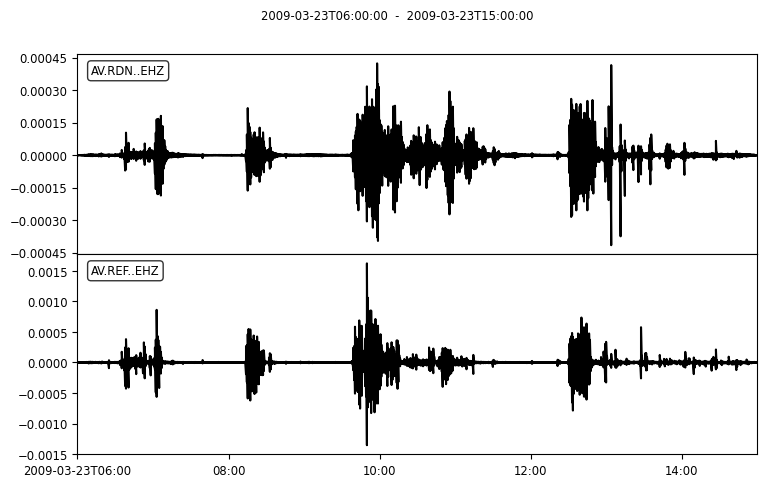

METRIC:  energy


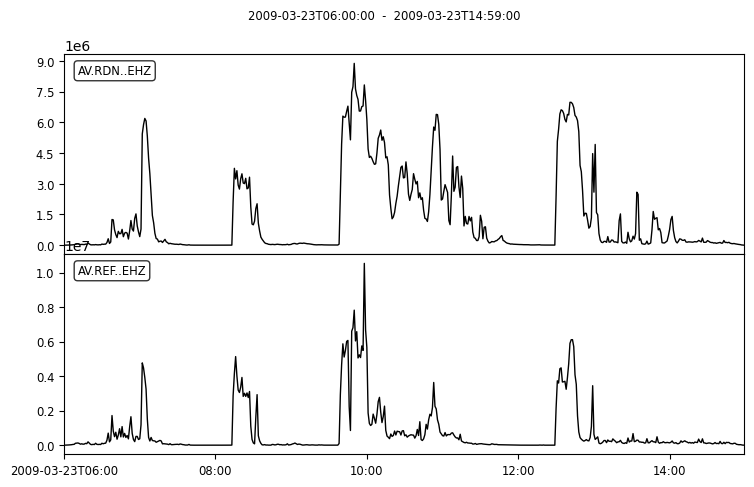

AV.RDN..EHZ: Joules: 7.28e+08, Magnitude: 3.8
AV.REF..EHZ: Joules: 4.02e+08, Magnitude: 3.6
Network: Joules: 5.65e+08, Magnitude: 3.7


In [7]:
from obspy.clients.filesystem.sds import Client as sdsclient
mySDSclient = sdsclient(SDS_DIR)
startt4 = obspy.UTCDateTime(2009,3,23,6,0,0)
endt4 = obspy.UTCDateTime(2009,3,23,15,0,0)
st = mySDSclient.get_waveforms("AV", "*", "*", "*", startt4, endt4)

pre_filt = [0.04, 0.05, 18, 25]
stationxml4 = os.path.join(RESPONSE_DIR, 'RD.xml')
inv = obspy.read_inventory(stationxml4)
st.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL", plot=False) 
st.plot(equal_scale=False);

vsemObj4 = VSEM(stream=st, sampling_interval=60)
#vsemObj4 = VSEM.read(startt4, endt4, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
#                     trace_ids=['AV.RDN..EHZ', 'AV.REF..EHZ'])
eventname4 = '2009/03/23 Redoubt Sub-Plinian eruptions'
source4 = {'lat':60.4845, 'lon':-152.7392}
compute_reduced_energies(eventname4, vsemObj4, source4, stationxml4, resultsDF)

### 3.5 Hunga Tonga eruption, Jan 15th, 2022

Our final example is Hunga Tonga, which on January 15th, 2022, exploded spectacularly, destroying most of the island, generating a tsunami, and seismic, pressure and gravity waves that propagated around the globe several times. 

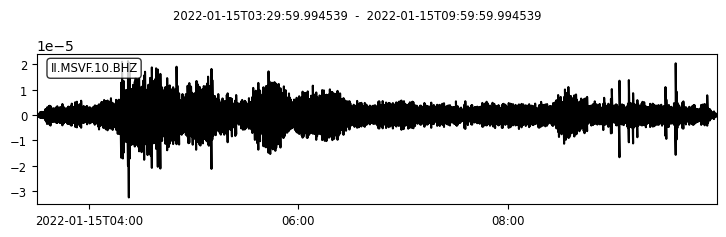

METRIC:  energy


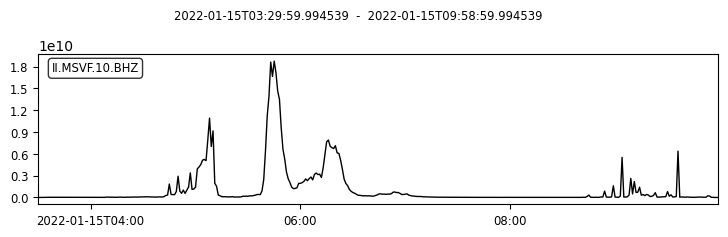

II.MSVF.10.BHZ: Joules: 4.29e+11, Magnitude: 5.6
Network: Joules: 4.29e+11, Magnitude: 5.6
II.MSVF.10.BHZ: Joules: 1.53e+14, Magnitude: 7.3
Network: Joules: 1.53e+14, Magnitude: 7.3


In [8]:
from obspy.clients.filesystem.sds import Client as sdsclient
eventname5 = 'Hunga Tonga, 2022/01/15'
mySDSclient = sdsclient(SDS_DIR)
startt5 = obspy.UTCDateTime(2022,1,15,3,30,0)
endt5 = obspy.UTCDateTime(2022,1,15,10,0,0)
st = mySDSclient.get_waveforms("II", "MSVF", "10", "BHZ", startt5, endt5)


pre_filt = [0.04, 0.05, 18, 25]
stationxml5 = os.path.join(RESPONSE_DIR, 'II.xml')
inv = obspy.read_inventory(stationxml5)
st.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL", plot=False) 
st.plot(equal_scale=False);

#################################################
# So far we just have a velocity seismogram
#################################################

# Generate a Velocity Seismic Energy Measurement (VSEM) object 
vsemObj5 = VSEM(stream=st, sampling_interval=60)

source5 = {'lat':-20.57, 'lon':-175.38}

compute_reduced_energies(eventname5, vsemObj5, source5, stationxml5, resultsDF)

## 4. Results

In [9]:
display(resultsDF)

,Event,sum(ER),ME,sum(ER_VLP),ME_VLP
0,Boxing Day Collapse 1997,2.396807e+09,4.11,0.000000e+00,-inf
1,"2003/07/12 collapse, Montserrat",1.308873e+10,4.61,7.984165e+08,3.80
2,"2019/12/09 Phreatic explosion, Whakaari",1.793914e+07,2.50,1.174039e+07,2.57
3,2009/03/23 Redoubt Sub-Plinian eruptions,5.649872e+08,3.68,0.000000e+00,-inf
4,"Hunga Tonga, 2022/01/15",4.286729e+11,5.62,1.533675e+14,7.32


The $M_E$ values here seem quite reasonable, but we have the same problem with the original Richter/Local Magnitude scale in that band-limited magnitude estimates do not scale well to larger events as the maximum energy tends to be radiated at lower frequencies. Maybe the $M_E^{VLP}$ of 7.3 for Hunga Tonga is reasonable to encapsulate the full radiated seismic wavefield of this event, although we should check by using a lot of stations at different azimuths and distances? This isn't really a problem though for very local, small volcano-seismic events, such as in the Montserrat seismic event catalog, for which the scale was originally developed.
